IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk import bigrams
from nltk import trigrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import pickle
from sklearn.preprocessing import MaxAbsScaler
import joblib
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,precision_score,recall_score,f1_score

LOADING DATA SET

In [2]:
data_set = "C:\\Users\\HP\\Downloads\\twitter_movie_reviews.csv"
data = pd.read_csv(data_set,encoding='latin1')
data = data.rename(columns={'review': 'text', 'sentiment': 'tag'})

DATA PREPROCESSING

In [3]:
def data_cleaning(text):
    #lower
    def to_lower(text):
        return text.lower()
    
    def remove_non_alphabetic(text):
        return ''.join(char for char in text if char.isalpha())

    # cleaning the data
    def punctuations(text):
        punctuations = '''()-[]{};:'",./?<>!@#$%^&*~`|'''
        no_punct = ""
        for char in text:
            if char not in punctuations:
                no_punct = no_punct + char
        pattern = r'[^\w\s]'
        regular_expression = re.sub(pattern, '', no_punct)
        return regular_expression

    # tokenisation
    def tokenize(text):
        tokens = nltk.word_tokenize(text)
        return tokens

    #stopword
    def rem_stopwords(text):
        no_sw = []
        stop_words = stopwords.words('english')
        stop_words.extend(list(string.ascii_lowercase))
        stop_words.append('br')
        for word in text:
            if word not in stop_words:
                no_sw.append(word)
        return no_sw

    #lemmatization
    def lemmatizing(text):
        lem = []
        lemmatizer = WordNetLemmatizer() 
        for word in text:
            le = lemmatizer.lemmatize(word)
            lem.append(le)
        return lem
    
    data['cleaned_text'] = data['text'].apply(to_lower).apply(punctuations).apply(tokenize).apply(rem_stopwords).apply(lemmatizing)
    new_data = data[['tag', 'cleaned_text']]    
    return new_data

In [4]:
print("_________________________________________________________________PROCESSED DATA___________________________________________________________________________")
print(data_cleaning(data))
new_data = data_cleaning(data)

_________________________________________________________________PROCESSED DATA___________________________________________________________________________
       tag                                       cleaned_text
0        1  [one, reviewer, mentioned, watching, 1, oz, ep...
1        1  [wonderful, little, production, filming, techn...
2        1  [thought, wonderful, way, spend, time, hot, su...
3        0  [basically, there, family, little, boy, jake, ...
4        1  [petter, matteis, love, time, money, visually,...
...    ...                                                ...
49995    1  [thought, movie, right, good, job, wasnt, crea...
49996    0  [bad, plot, bad, dialogue, bad, acting, idioti...
49997    0  [catholic, taught, parochial, elementary, scho...
49998    0  [im, going, disagree, previous, comment, side,...
49999    0  [one, expects, star, trek, movie, high, art, f...

[50000 rows x 2 columns]


BAR PLOT OF POSITIVE AND NEGATIVE REVIEWS

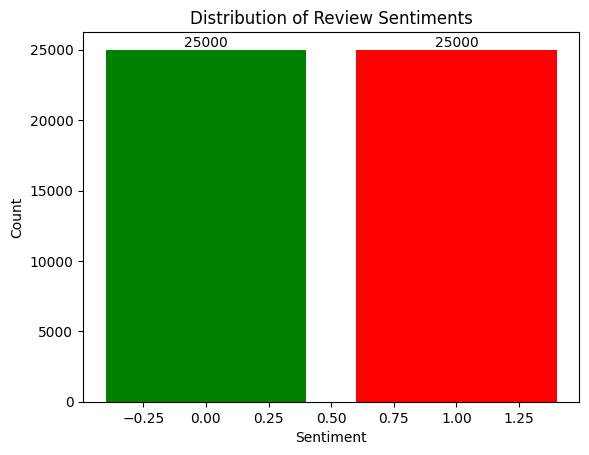

In [5]:
def barplot():
    new_data['sentiment'] = new_data['tag'].apply(lambda x:1 if x == 1 else 0)
    sentiment_counts = new_data['sentiment'].value_counts()
    bars = plt.bar(sentiment_counts.index,sentiment_counts.values, color=['red', 'green'])
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Distribution of Review Sentiments')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')
    return plt.show()

barplot()

WORDCLOUD OF POSITIVE AND NEGATIVE REVIEWS

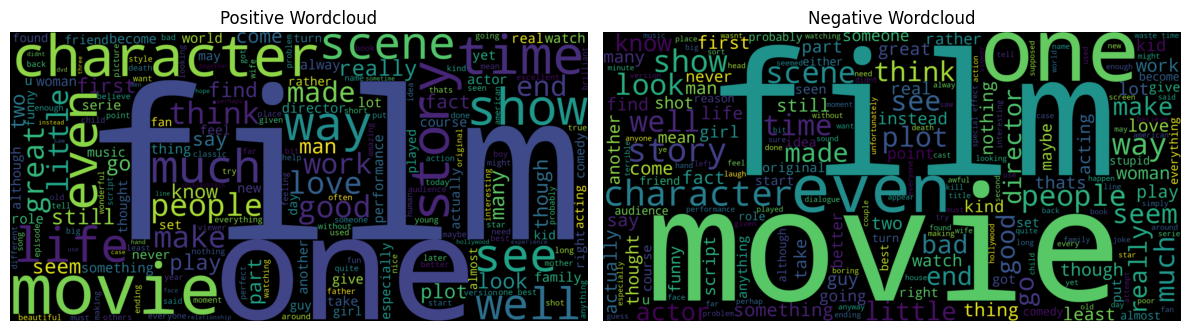

In [6]:
def word_cloud():

    positive_review = new_data[new_data['tag'] == 1]['cleaned_text'].dropna()
    negative_review = new_data[new_data['tag'] == 0]['cleaned_text'].dropna()

    positive_words = [word for review in positive_review for word in review]
    negative_words = [word for review in negative_review for word in review]

    positive = ' '.join(positive_words)
    negative = ' '.join(negative_words)

    positive_wordcloud = WordCloud(width=3000, height=1500, background_color='black').generate(positive)
    negative_wordcloud = WordCloud(width=3000, height=1500, background_color='black').generate(negative)

    plt.figure(figsize=(12,6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.title('Positive Wordcloud')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.title('Negative Wordcloud')
    plt.axis('off')

    plt.tight_layout()

    return plt.show()

word_cloud()

PLOT OF COMMON UNIGRAMS IN POSITIVE AND NEGATIVE REVIEWS

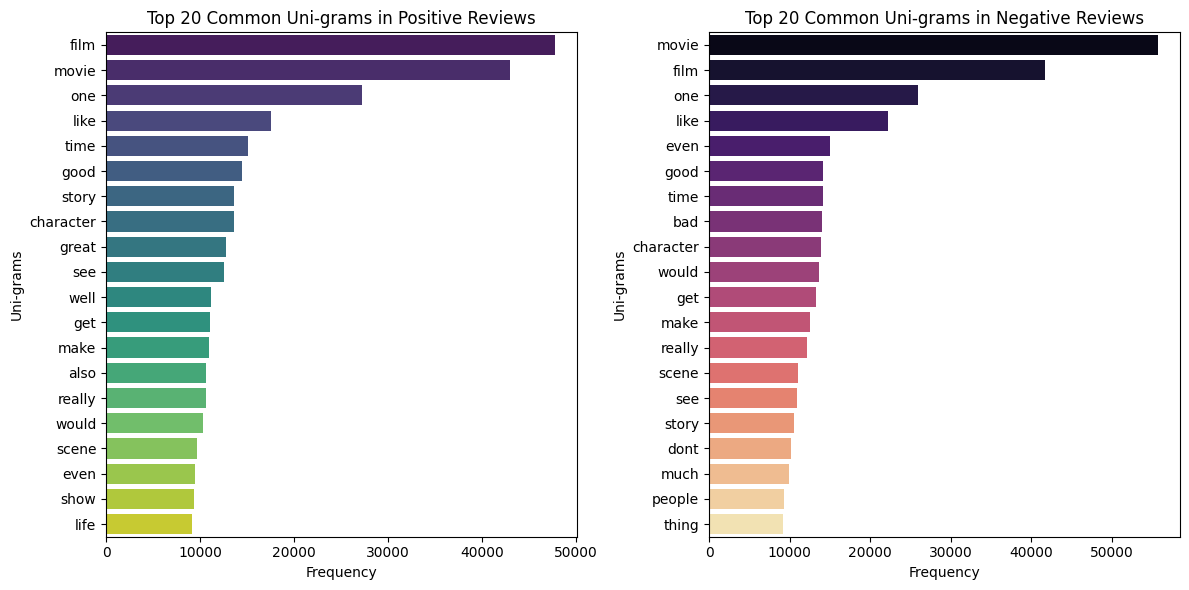

In [7]:
def common_unigrams():
    
    # Filter positive and negative reviews
    positive_reviews = new_data[new_data['tag'] == 1]['cleaned_text'].dropna()
    negative_reviews = new_data[new_data['tag'] == 0]['cleaned_text'].dropna()


    # Flatten lists of words for positive and negative reviews
    all_positive_words = [word for review in positive_reviews for word in review]
    all_negative_words = [word for review in negative_reviews for word in review]

    # Count word frequencies
    word_counts_positive = Counter(all_positive_words)
    word_counts_negative = Counter(all_negative_words)

    # Get top 10 most common words
    top_counts_positive = word_counts_positive.most_common(20)
    top_counts_negative = word_counts_negative.most_common(20)

    # Convert to DataFrame for plotting
    top_counts_positive_df = pd.DataFrame(top_counts_positive, columns=['word', 'frequency'])
    top_counts_negative_df = pd.DataFrame(top_counts_negative, columns=['word', 'frequency'])

    plt.figure(figsize=(12,6))

    # Plotting
    plt.subplot(1, 2, 1)
    sns.barplot(x='frequency', y='word', data=top_counts_positive_df, palette='viridis', hue='word', dodge=False)
    plt.title('Top 20 Common Uni-grams in Positive Reviews')
    plt.xlabel('Frequency')
    plt.ylabel('Uni-grams')

    plt.subplot(1, 2, 2)
    sns.barplot(x='frequency', y='word', data=top_counts_negative_df, palette='magma', hue='word', dodge=False)
    plt.title('Top 20 Common Uni-grams in Negative Reviews')
    plt.xlabel('Frequency')
    plt.ylabel('Uni-grams')

    plt.tight_layout()
    plt.show()
    
common_unigrams()

PLOT OF COMMON BI-GRAMS IN POSITIVE AND NEGATIVE REVIEWS

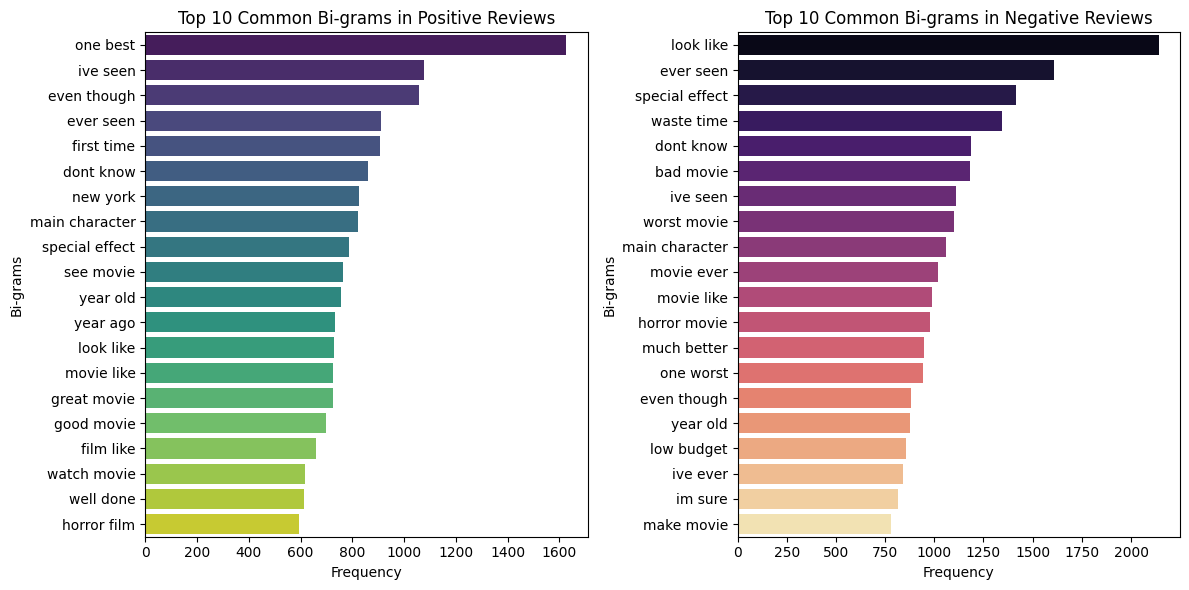

In [8]:
def common_bigrams():

    positive_reviews = new_data[new_data['tag'] == 1]['cleaned_text'].dropna()
    negative_reviews = new_data[new_data['tag'] == 0]['cleaned_text'].dropna()

    all_positive_words = [word for review in positive_reviews for word in review]
    all_negative_words = [word for review in negative_reviews for word in review]

    bi_grams_positive = list(bigrams(all_positive_words))
    bi_grams_negative = list(bigrams(all_negative_words))

    word_counts_positive = Counter(bi_grams_positive)
    word_counts_negative = Counter(bi_grams_negative)

    top_counts_positive = word_counts_positive.most_common(20)
    top_counts_negative = word_counts_negative.most_common(20)

    top_counts_positive_df = pd.DataFrame(top_counts_positive, columns=['word', 'frequency'])
    top_counts_positive_df['word'] = top_counts_positive_df['word'].apply(lambda x:' '.join(x))

    top_counts_negative_df = pd.DataFrame(top_counts_negative, columns=['word', 'frequency'])
    top_counts_negative_df['word'] = top_counts_negative_df['word'].apply(lambda x:' '.join(x))

    plt.figure(figsize=(12,6))

    plt.subplot(1, 2, 1)
    sns.barplot(x='frequency', y='word', data=top_counts_positive_df, palette='viridis', hue='word', dodge=False)
    plt.title('Top 10 Common Bi-grams in Positive Reviews')
    plt.xlabel('Frequency')
    plt.ylabel('Bi-grams')

    plt.subplot(1, 2, 2)
    sns.barplot(x='frequency', y='word', data=top_counts_negative_df, palette='magma', hue='word', dodge=False)
    plt.title('Top 10 Common Bi-grams in Negative Reviews')
    plt.xlabel('Frequency')
    plt.ylabel('Bi-grams')

    plt.tight_layout()

    return plt.show()

common_bigrams()

PLOT OF COMMON TRI-GRAMS IN POSITIVE AND NEGATIVE REVIEWS

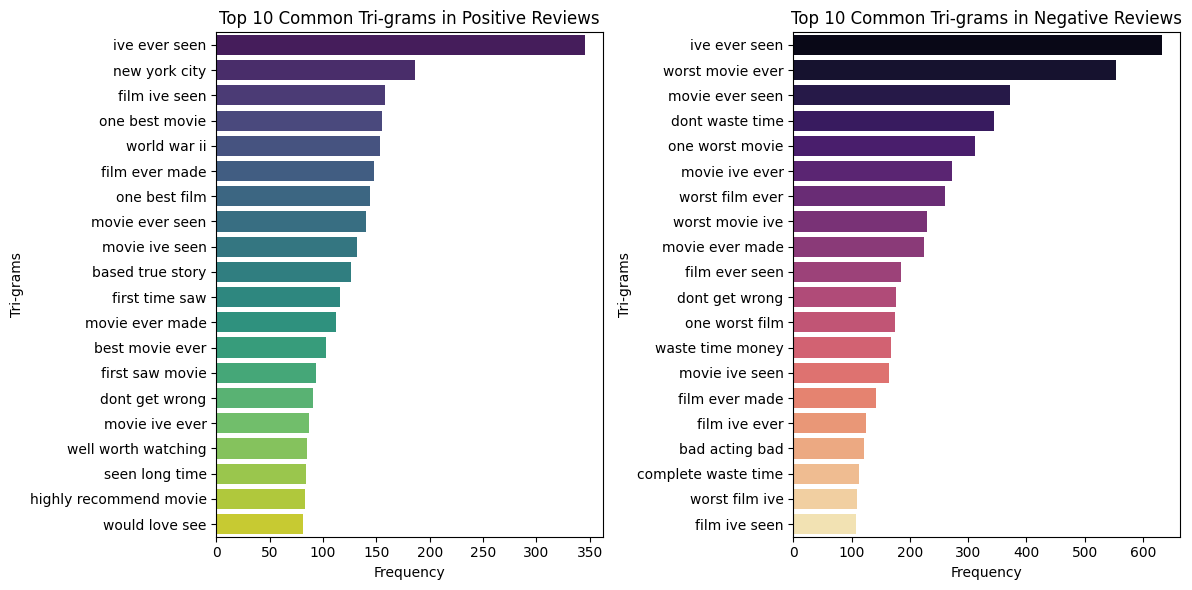

In [9]:
def common_trigrams():

    # Filter positive and negative reviews
    positive_reviews = new_data[new_data['tag'] == 1]['cleaned_text'].dropna()
    negative_reviews = new_data[new_data['tag'] == 0]['cleaned_text'].dropna()


    all_positive_words = [word for review in positive_reviews for word in review]
    all_negative_words = [word for review in negative_reviews for word in review]

    tri_grams_positive = list(trigrams(all_positive_words))
    tri_grams_negative = list(trigrams(all_negative_words))

    word_counts_positive = Counter(tri_grams_positive)
    word_counts_negative = Counter(tri_grams_negative)

    top_counts_positive = word_counts_positive.most_common(20)
    top_counts_negative = word_counts_negative.most_common(20)

    top_counts_positive_df = pd.DataFrame(top_counts_positive, columns=['word', 'frequency'])
    top_counts_positive_df['word'] = top_counts_positive_df['word'].apply(lambda x:' '.join(x))

    top_counts_negative_df = pd.DataFrame(top_counts_negative, columns=['word', 'frequency'])
    top_counts_negative_df['word'] = top_counts_negative_df['word'].apply(lambda x:' '.join(x))

    plt.figure(figsize=(12,6))

    plt.subplot(1, 2, 1)
    sns.barplot(x='frequency', y='word', data=top_counts_positive_df, palette='viridis', hue='word', dodge=False)
    plt.title('Top 10 Common Tri-grams in Positive Reviews')
    plt.xlabel('Frequency')
    plt.ylabel('Tri-grams')

    plt.subplot(1, 2, 2)
    sns.barplot(x='frequency', y='word', data=top_counts_negative_df, palette='magma', hue='word', dodge=False)
    plt.title('Top 10 Common Tri-grams in Negative Reviews')
    plt.xlabel('Frequency')
    plt.ylabel('Tri-grams')

    plt.tight_layout()

    return plt.show()

common_trigrams()

MODEL SELECTION AND TRAINING

In [10]:
new_data.loc[:, 'cleaned_text'] = new_data['cleaned_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
tfid = TfidfVectorizer(max_features=5000)

x = tfid.fit_transform(new_data['cleaned_text'])
y = new_data['tag']

print(x)
print(y)

  (0, 3990)	0.05771441664076922
  (0, 1138)	0.0923981064248034
  (0, 4548)	0.0670711311873074
  (0, 4651)	0.08901165029837552
  (0, 896)	0.09104772600536884
  (0, 441)	0.05613918654731665
  (0, 2764)	0.04604437038868142
  (0, 1585)	0.05855346880183921
  (0, 4037)	0.07376588339672197
  (0, 4243)	0.0649498906285809
  (0, 2505)	0.05674385089666829
  (0, 4625)	0.0623039014858268
  (0, 829)	0.06531174135855966
  (0, 2816)	0.06446820331064498
  (0, 4859)	0.03250394468131625
  (0, 375)	0.04796433871013294
  (0, 1897)	0.06015228685934886
  (0, 3117)	0.06088669853485291
  (0, 2472)	0.05588927958977201
  (0, 2287)	0.20472239826042551
  (0, 4083)	0.08733047810778205
  (0, 1988)	0.0837203342777641
  (0, 1954)	0.07539668065680785
  (0, 2578)	0.0604490920268116
  (0, 1939)	0.04407271930905993
  :	:
  (49999, 4950)	0.09971330671962993
  (49999, 666)	0.08884991211327117
  (49999, 4183)	0.09560987741773744
  (49999, 2972)	0.09977311301188645
  (49999, 1930)	0.057802435357366296
  (49999, 472)	0.0772233

SPLITTING THE DATA INTO TEST AND TRAIN AND TRAINING WITH DIFFERENT MODELS

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [12]:
print(y_test)

33553    1
9427     1
199      0
12447    1
39489    0
        ..
28567    0
25079    1
18707    1
15200    0
5857     1
Name: tag, Length: 10000, dtype: int64


In [13]:
print(x_test)

  (0, 398)	0.30127906973667856
  (0, 2743)	0.15296179161001652
  (0, 2397)	0.11616234573371718
  (0, 2045)	0.2827473494326623
  (0, 1901)	0.10564124497042822
  (0, 270)	0.1288431429391991
  (0, 1665)	0.11186492371024764
  (0, 675)	0.1171654132833747
  (0, 4069)	0.12759229772001374
  (0, 1235)	0.1188828860251886
  (0, 1222)	0.0963684073104932
  (0, 1910)	0.10110754196513293
  (0, 3138)	0.07879991948584301
  (0, 4417)	0.12617157943348503
  (0, 4254)	0.08643777269967638
  (0, 2948)	0.09307237844214417
  (0, 67)	0.11768645853812411
  (0, 530)	0.1716757985260145
  (0, 4267)	0.08424805903121423
  (0, 1539)	0.25573516704345045
  (0, 1477)	0.07133557391447745
  (0, 740)	0.10176356817957567
  (0, 4435)	0.31626490796196943
  (0, 217)	0.06535606876934187
  (0, 4519)	0.07807258171831015
  :	:
  (9999, 1334)	0.06990828849034111
  (9999, 1894)	0.15030934588736297
  (9999, 164)	0.12653790186065791
  (9999, 2224)	0.08573171543031365
  (9999, 3830)	0.13403575549596694
  (9999, 2915)	0.06706945001873497

LINEAR REGRESSINON

In [14]:
lg_model = LinearRegression()
lg_model.fit(x_train, y_train)

# Predict continuous outputs
y_pred_lg = lg_model.predict(x_test)
y_train_pred_lg = lg_model.predict(x_train)

# Convert continuous predictions to binary predictions
threshold = 0.5
y_pred_lg_binary = (y_pred_lg >= threshold).astype(int)
y_train_pred_lg_binary = (y_train_pred_lg >= threshold).astype(int)

# Evaluate binary classification metrics
train_accuracy_lg = accuracy_score(y_train, y_train_pred_lg_binary)
test_accuracy_lg = accuracy_score(y_test, y_pred_lg_binary)
classification_lg = classification_report(y_test, y_pred_lg_binary)
precision_lg = precision_score(y_test, y_pred_lg_binary, average='weighted')
recall_lg = recall_score(y_test, y_pred_lg_binary, average='weighted')
f1_lg = f1_score(y_test, y_pred_lg_binary, average='weighted')
confusion_lg = confusion_matrix(y_test, y_pred_lg_binary)

print('____________________________________________________')
print('Training Accuracy: ')
print(train_accuracy_lg)
print('____________________________________________________')
print('Testing Accuracy: ')
print(test_accuracy_lg)
print('____________________________________________________')
print('Classification Report: ')
print(classification_lg)
print('____________________________________________________')
print('Confusion Matrix: ')
print(confusion_lg)
print('____________________________________________________')

____________________________________________________
Training Accuracy: 
0.9208
____________________________________________________
Testing Accuracy: 
0.8754
____________________________________________________
Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.86      0.87      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

____________________________________________________
Confusion Matrix: 
[[4268  693]
 [ 553 4486]]
____________________________________________________


SUPPORT VECTOR MACHINE(SVM)

In [15]:
svm_model = LinearSVC(dual='auto')
svm_model.fit(x_train,y_train)

y_pred_svm = svm_model.predict(x_test)
y_train_pred_svm = svm_model.predict(x_train)

train_accuracy_svm = accuracy_score(y_train_pred_svm,y_train)
accuracy_svm = accuracy_score(y_pred_svm,y_test)
classification_svm = classification_report(y_pred_svm,y_test)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
confusion_svm = confusion_matrix(y_pred_svm,y_test)

print('____________________________________________________')
print('Training Accuracy: ')
print(train_accuracy_svm)
print('____________________________________________________')
print('Testing Accuracy: ')
print(accuracy_svm)
print('____________________________________________________')
print('Classification Report: ')
print(classification_svm)
print('____________________________________________________')
print('Confusion Matrix: ')
print(confusion_svm)
print('____________________________________________________')

____________________________________________________
Training Accuracy: 
0.931025
____________________________________________________
Testing Accuracy: 
0.8801
____________________________________________________
Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4884
           1       0.89      0.88      0.88      5116

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

____________________________________________________
Confusion Matrix: 
[[4323  561]
 [ 638 4478]]
____________________________________________________


RANDOM FOREST

In [16]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train,y_train)

y_pred_rf = rf_model.predict(x_test)
y_train_pred_rf = rf_model.predict(x_train)

train_accuracy_rf = accuracy_score(y_train_pred_rf,y_train)
accuracy_rf = accuracy_score(y_pred_rf,y_test)
classification_rf = classification_report(y_pred_rf,y_test)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
confusion_rf = confusion_matrix(y_pred_rf,y_test)

print('____________________________________________________')
print('Training Accuracy: ')
print(train_accuracy_rf)
print('____________________________________________________')
print('Testing Accuracy: ')
print(accuracy_rf)
print('____________________________________________________')
print('Classification Report: ')
print(classification_rf)
print('____________________________________________________')
print('Confusion Matrix: ')
print(confusion_rf)
print('____________________________________________________')

____________________________________________________
Training Accuracy: 
1.0
____________________________________________________
Testing Accuracy: 
0.8488
____________________________________________________
Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      5065
           1       0.84      0.86      0.85      4935

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

____________________________________________________
Confusion Matrix: 
[[4257  808]
 [ 704 4231]]
____________________________________________________


XGBOOST

In [17]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train_encoded)

y_pred_xgb = xgb_model.predict(x_test)
y_train_pred_xgb = xgb_model.predict(x_train)

train_accuracy_xgb = accuracy_score(y_train_pred_xgb,y_train_encoded)
accuracy_xgb = accuracy_score(y_pred_xgb,y_test_encoded)
classification_xgb = classification_report(y_pred_xgb,y_test_encoded)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
confusion_xgb = confusion_matrix(y_pred_xgb,y_test_encoded)

print('____________________________________________________')
print('Training Accuracy: ')
print(train_accuracy_xgb)
print('____________________________________________________')
print('Testing Accuracy: ')
print(accuracy_xgb)
print('____________________________________________________')
print('Classification Report: ')
print(classification_xgb)
print('____________________________________________________')
print('Confusion Matrix: ')
print(confusion_xgb)
print('____________________________________________________')


____________________________________________________
Training Accuracy: 
0.92605
____________________________________________________
Testing Accuracy: 
0.8599
____________________________________________________
Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      4714
           1       0.89      0.84      0.86      5286

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

____________________________________________________
Confusion Matrix: 
[[4137  577]
 [ 824 4462]]
____________________________________________________


NAIVE BAYES

In [18]:
nb_model = MultinomialNB()
nb_model.fit(x_train,y_train)

y_pred_nb = nb_model.predict(x_test)
y_train_pred_nb = nb_model.predict(x_train)

train_accuracy_nb = accuracy_score(y_train_pred_nb,y_train)
accuracy_nb = accuracy_score(y_pred_nb,y_test)
classification_nb = classification_report(y_pred_nb,y_test)
precision_nb = precision_score(y_test, y_pred_nb, average='weighted')
recall_nb = recall_score(y_test, y_pred_nb, average='weighted')
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')
confusion_nb = confusion_matrix(y_pred_nb,y_test)

print('____________________________________________________')
print('Training Accuracy: ')
print(train_accuracy_nb)
print('____________________________________________________')
print('Testing Accuracy: ')
print(accuracy_nb)
print('____________________________________________________')
print('Classification Report: ')
print(classification_nb)
print('____________________________________________________')
print('Confusion Matrix: ')
print(confusion_nb)
print('____________________________________________________')

____________________________________________________
Training Accuracy: 
0.865175
____________________________________________________
Testing Accuracy: 
0.8543
____________________________________________________
Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      4930
           1       0.86      0.85      0.86      5070

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

____________________________________________________
Confusion Matrix: 
[[4217  713]
 [ 744 4326]]
____________________________________________________


CROSS VALIDATION

In [19]:
# cross validation
cv_accuracy = cross_val_score(estimator=nb_model,X=x_train,y=y_train,cv=10)

print('____________________________________________________')
print('Cross Validation Accuracy(mean): ')
print(cv_accuracy.mean())
print('____________________________________________________')

____________________________________________________
Cross Validation Accuracy(mean): 
0.854875
____________________________________________________


HYPERPARAMETER TUNING WITH GRID SEARCH

In [20]:
parameter_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]}
gridsearch = GridSearchCV(estimator=nb_model,param_grid = parameter_grid,cv=100,return_train_score=True)
gridsearch.fit(x_train,y_train)
print('____________________________________________________')
print(gridsearch.best_estimator_)
print("______________________________________________________")

____________________________________________________
MultinomialNB(alpha=0.1)
______________________________________________________


In [21]:
print('____________________________________________________')
print("Cross validation mean accuracy on train set : {}".format(gridsearch.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(gridsearch.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_nb)
print("______________________________________________________")

____________________________________________________
Cross validation mean accuracy on train set : 85.40694128787878
Cross validation mean accuracy on test set : 84.54531250000001
Accuracy score for test set : 0.8543
______________________________________________________


PLOTTING LEARNING CURVE

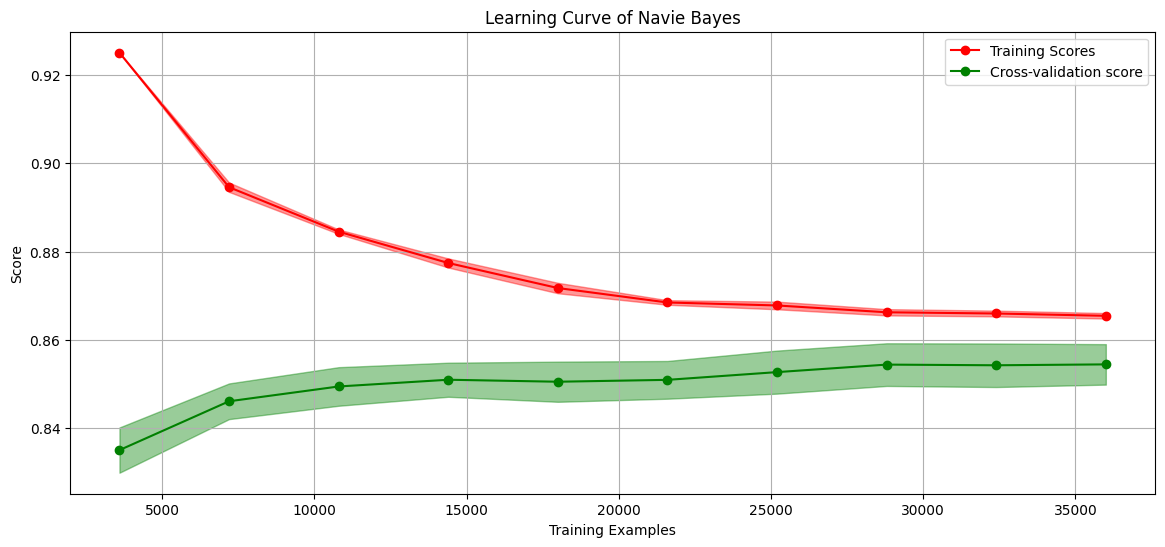

In [22]:
train_size_nb = np.linspace(0.1, 1.0, 10)
train_size_nb, train_score_nb, test_score_nb = learning_curve(gridsearch.best_estimator_,x_train,y_train,cv=10,n_jobs=-1,train_sizes=train_size_nb,return_times=False)

train_mean_nb= np.mean(train_score_nb, axis=1)
train_std_nb = np.std(train_score_nb, axis=1)

test_mean_nb= np.mean(test_score_nb, axis=1)
test_std_nb = np.std(test_score_nb, axis=1)

plt.figure(figsize=(14,6))
plt.plot(train_size_nb,train_mean_nb,'o-',color='r',label='Training Scores')
plt.plot(train_size_nb, test_mean_nb, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_size_nb, train_mean_nb - train_std_nb, train_mean_nb + train_std_nb, color='r', alpha=0.4)
plt.fill_between(train_size_nb, test_mean_nb - test_std_nb, test_mean_nb + test_std_nb, color='g', alpha=0.4)
plt.title('Learning Curve of Navie Bayes')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

LOGISTIC REGRESSION

In [23]:
lr_model = LogisticRegression()
lr_model.fit(x_train,y_train)

y_pred_lr = lr_model.predict(x_test)
y_train_pred_lr = lr_model.predict(x_train)

train_accuracy_lr = accuracy_score(y_train_pred_lr,y_train)
accuracy_lr = accuracy_score(y_pred_lr,y_test)
classification_lr = classification_report(y_pred_lr,y_test)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
confusion_lr = confusion_matrix(y_pred_lr,y_test)

print('____________________________________________________')
print('Training Accuracy: ')
print(train_accuracy_lr)
print('____________________________________________________')
print('Testing Accuracy: ')
print(accuracy_lr)
print('____________________________________________________')
print('Classification Report: ')
print(classification_lr)
print('____________________________________________________')
print('Confusion Matrix: ')
print(confusion_lr)
print('____________________________________________________')

____________________________________________________
Training Accuracy: 
0.9114
____________________________________________________
Testing Accuracy: 
0.8869
____________________________________________________
Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      4820
           1       0.90      0.88      0.89      5180

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

____________________________________________________
Confusion Matrix: 
[[4325  495]
 [ 636 4544]]
____________________________________________________


PLOTTING THE LEARNING CURVE

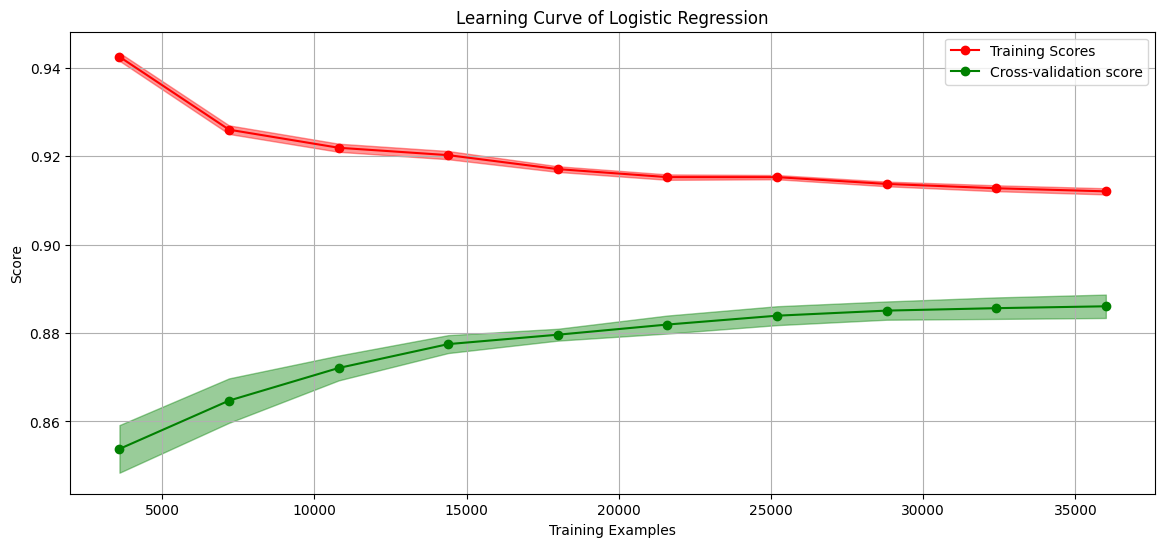

In [24]:
train_size_lr = np.linspace(0.1, 1.0, 10)
train_size_lr, train_score_lr, test_score_lr = learning_curve(lr_model,x_train,y_train,cv=10,n_jobs=-1,train_sizes=train_size_lr,return_times=False)

train_mean_lr = np.mean(train_score_lr, axis=1)
train_std_lr = np.std(train_score_lr, axis=1)

test_mean_lr = np.mean(test_score_lr, axis=1)
test_std_lr = np.std(test_score_lr, axis=1)

plt.figure(figsize=(14,6))
plt.plot(train_size_lr,train_mean_lr,'o-',color='r',label='Training Scores')
plt.plot(train_size_lr, test_mean_lr, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_size_lr, train_mean_lr - train_std_lr, train_mean_lr + train_std_lr, color='r', alpha=0.4)
plt.fill_between(train_size_lr, test_mean_lr - test_std_lr, test_mean_lr + test_std_lr, color='g', alpha=0.4)
plt.title('Learning Curve of Logistic Regression')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

COMPARISION GRAPHS

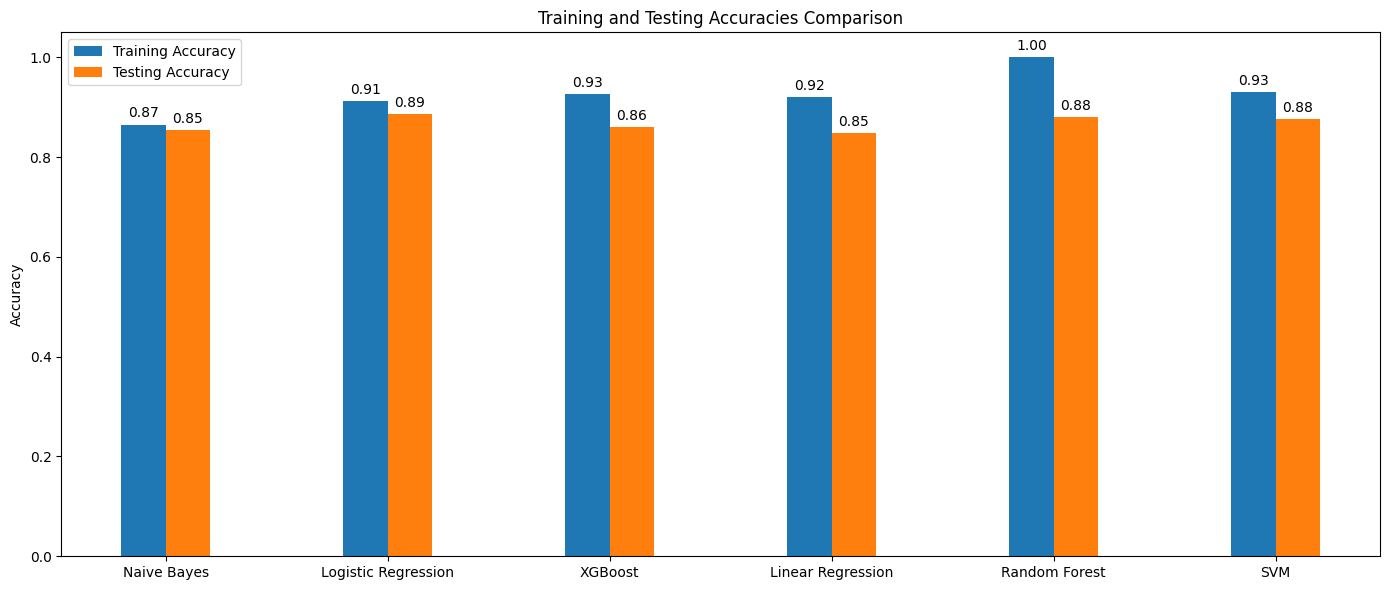

In [25]:
labels = ['Naive Bayes', 'Logistic Regression', 'XGBoost','Linear Regression','Random Forest','SVM']
train_accuracies = [train_accuracy_nb, train_accuracy_lr, train_accuracy_xgb,train_accuracy_lg,train_accuracy_rf,train_accuracy_svm]
test_accuracies = [accuracy_nb, accuracy_lr, accuracy_xgb,accuracy_rf,accuracy_svm,test_accuracy_lg]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 6))

rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Testing Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Training and Testing Accuracies Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add numerical values on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

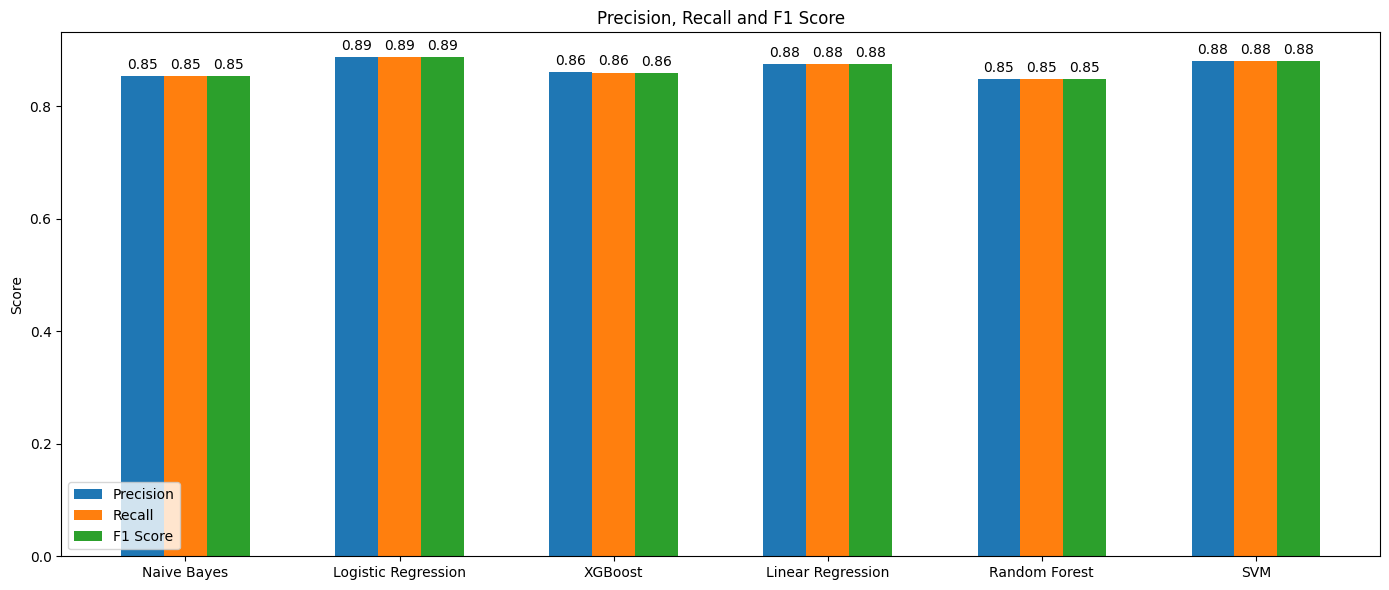

In [26]:
labels = ['Naive Bayes', 'Logistic Regression', 'XGBoost','Linear Regression','Random Forest','SVM']
precision_scores = [precision_nb, precision_lr, precision_xgb,precision_lg,precision_rf,precision_svm]
recall_scores = [recall_nb, recall_lr, recall_xgb,recall_lg,recall_rf,recall_svm]
f1_scores = [f1_nb, f1_lr,f1_xgb,f1_lg,f1_rf,f1_svm]

x = np.arange(len(labels))
width = 0.2  # Adjust the width to fit three sets of bars

fig, ax = plt.subplots(figsize=(14, 6))

# Adjust positions to avoid overlap
rects1 = ax.bar(x - width, precision_scores, width, label='Precision')
rects2 = ax.bar(x, recall_scores, width, label='Recall')
rects3 = ax.bar(x + width, f1_scores, width, label='F1 Score')

ax.set_ylabel('Score')
ax.set_title('Precision, Recall and F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add numerical values on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()


plt.show()

In [27]:
with open('model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

In [28]:
with open('vector.pkl', 'wb') as f:
    pickle.dump(tfid, f)

In [29]:
from nltk.tokenize import word_tokenize

In [30]:
def data_cleaning(text):
    text = text.lower()
    text = ''.join(char for char in text if char.isalpha() or char.isspace())
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english')).union(set(string.ascii_lowercase), {'br'})
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [31]:
def prediction(comment):
    preprocessed_comment = data_cleaning(comment)
    comment_list = [preprocessed_comment]
    comment_vector = tfid.transform(comment_list)
    predicted_sentiment = lr_model.predict(comment_vector)[0]
    return "Positive" if predicted_sentiment == 1 else "Negative"

prediction = prediction("My egg  are getting good, I had to have a livener this morning just to see me through to proper breakfast ")
print(prediction)

Positive
